***Prueba de MIL con rsna usando features de ResNet-18***

In [2]:
import sys
print(sys.executable)

/home/javitrucas/miniconda3/envs/tfg/bin/python


In [3]:
import torch
import wandb
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import sys
import os

# Agregar el directorio raíz del proyecto a sys.path
project_root = "/home/javitrucas/TFG"
if project_root not in sys.path:
    sys.path.append(project_root)

In [6]:
from scripts.dataset_loader import load_dataset
from scripts.medical_scripts.medical_evaluation import ModelEvaluator
from scripts.medical_scripts.medical_training import Training
from scripts.MIL_utils import MIL_collate_fn

from types import SimpleNamespace
from box import Box

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_results(results):
    """
    Visualiza las métricas de entrenamiento, validación y prueba.
    Los resultados deben contener claves específicas para cada métrica.
    """
    
    # 1. Matriz de confusión
    if "confusion_matrix" in results:
        cm = results["confusion_matrix"]
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()

    # 2. Curvas de pérdida (loss)
    if "train_loss_curve" in results or "val_loss_curve" in results or "test_loss_curve" in results:
        plt.figure(figsize=(10, 6))
        if "train_loss_curve" in results:
            plt.plot(results["train_loss_curve"], label="Training Loss", color="blue")
        if "val_loss_curve" in results:
            plt.plot(results["val_loss_curve"], label="Validation Loss", color="orange")
        if "test_loss_curve" in results:
            plt.plot(results["test_loss_curve"], label="Test Loss", color="green")
        plt.title("Loss Curves")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid()
        plt.show()

    # 3. Curvas de precisión (accuracy)
    if "train_accuracy_curve" in results or "val_accuracy_curve" in results or "test_accuracy_curve" in results:
        plt.figure(figsize=(10, 6))
        if "train_accuracy_curve" in results:
            plt.plot(results["train_accuracy_curve"], label="Training Accuracy", color="blue")
        if "val_accuracy_curve" in results:
            plt.plot(results["val_accuracy_curve"], label="Validation Accuracy", color="orange")
        if "test_accuracy_curve" in results:
            plt.plot(results["test_accuracy_curve"], label="Test Accuracy", color="green")
        plt.title("Accuracy Curves")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.grid()
        plt.show()

    # 4. F1-Score
    if "train_f1_score" in results or "val_f1_score" in results or "test_f1_score" in results:
        plt.figure(figsize=(10, 6))
        if "train_f1_score" in results:
            plt.plot(results["train_f1_score"], label="Training F1-Score", color="blue")
        if "val_f1_score" in results:
            plt.plot(results["val_f1_score"], label="Validation F1-Score", color="orange")
        if "test_f1_score" in results:
            plt.plot(results["test_f1_score"], label="Test F1-Score", color="green")
        plt.title("F1-Score Curves")
        plt.xlabel("Epochs")
        plt.ylabel("F1-Score")
        plt.legend()
        plt.grid()
        plt.show()

    # 5. AUC-ROC
    if "train_auc_roc" in results or "val_auc_roc" in results or "test_auc_roc" in results:
        plt.figure(figsize=(10, 6))
        if "train_auc_roc" in results:
            plt.plot(results["train_auc_roc"], label="Training AUC-ROC", color="blue")
        if "val_auc_roc" in results:
            plt.plot(results["val_auc_roc"], label="Validation AUC-ROC", color="orange")
        if "test_auc_roc" in results:
            plt.plot(results["test_auc_roc"], label="Test AUC-ROC", color="green")
        plt.title("AUC-ROC Curves")
        plt.xlabel("Epochs")
        plt.ylabel("AUC-ROC")
        plt.legend()
        plt.grid()
        plt.show()

    # 6. Precision
    if "train_precision" in results or "val_precision" in results or "test_precision" in results:
        plt.figure(figsize=(10, 6))
        if "train_precision" in results:
            plt.plot(results["train_precision"], label="Training Precision", color="blue")
        if "val_precision" in results:
            plt.plot(results["val_precision"], label="Validation Precision", color="orange")
        if "test_precision" in results:
            plt.plot(results["test_precision"], label="Test Precision", color="green")
        plt.title("Precision Curves")
        plt.xlabel("Epochs")
        plt.ylabel("Precision")
        plt.legend()
        plt.grid()
        plt.show()

    # 7. Recall
    if "train_recall" in results or "val_recall" in results or "test_recall" in results:
        plt.figure(figsize=(10, 6))
        if "train_recall" in results:
            plt.plot(results["train_recall"], label="Training Recall", color="blue")
        if "val_recall" in results:
            plt.plot(results["val_recall"], label="Validation Recall", color="orange")
        if "test_recall" in results:
            plt.plot(results["test_recall"], label="Test Recall", color="green")
        plt.title("Recall Curves")
        plt.xlabel("Epochs")
        plt.ylabel("Recall")
        plt.legend()
        plt.grid()
        plt.show()

    # 8. AUROC (Area Under the Receiver Operating Characteristic Curve)
    if "train_auroc" in results or "val_auroc" in results or "test_auroc" in results:
        plt.figure(figsize=(10, 6))
        if "train_auroc" in results:
            plt.plot(results["train_auroc"], label="Training AUROC", color="blue")
        if "val_auroc" in results:
            plt.plot(results["val_auroc"], label="Validation AUROC", color="orange")
        if "test_auroc" in results:
            plt.plot(results["test_auroc"], label="Test AUROC", color="green")
        plt.title("AUROC Curves")
        plt.xlabel("Epochs")
        plt.ylabel("AUROC")
        plt.legend()
        plt.grid()
        plt.show()

    # 9. Learning Rate (si está disponible)
    if "learning_rate" in results:
        plt.figure(figsize=(10, 6))
        plt.plot(results["learning_rate"], label="Learning Rate", color="purple")
        plt.title("Learning Rate Schedule")
        plt.xlabel("Epochs")
        plt.ylabel("Learning Rate")
        plt.legend()
        plt.grid()
        plt.show()

        # Curvas de entrenamiento y validación
        plt.figure(figsize=(10, 5))
        plt.plot(results["train_loss_curve"], label="Training Loss")
        plt.plot(results["val_loss_curve"], label="Validation Loss")
        plt.title("Loss Curves")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()

        plt.figure(figsize=(10, 5))
        plt.plot(results["train_accuracy_curve"], label="Training Accuracy")
        plt.plot(results["val_accuracy_curve"], label="Validation Accuracy")
        plt.title("Accuracy Curves")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.show()

        # Métricas de prueba (escalares)
        print("\n--- Test Results ---")
        print(f"Accuracy: {results['test_metrics']['accuracy']:.4f}")
        print(f"AUC: {results['test_metrics']['auc']:.4f}")
        print(f"F1-Score: {results['test_metrics']['f1_score']:.4f}")
        print(f"Precision: {results['test_metrics']['precision']:.4f}")
        print(f"Recall: {results['test_metrics']['recall']:.4f}")
        
        # Matriz de confusión
        if "confusion_matrix" in results['test_metrics']:
            cm = results['test_metrics']["confusion_matrix"]
            plt.figure(figsize=(8, 6))
            sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
            plt.title("Confusion Matrix (Test)")
            plt.xlabel("Predicted")
            plt.ylabel("True")
            plt.show()

In [8]:
def run_experiment(config):
    # Crear un objeto temporal para compatibilidad
    class TempConfig:
        def __init__(self, config_dict):
            self.__dict__.update(config_dict)

    config_obj = TempConfig(config)

    # Iniciar wandb
    wandb.init(
        project="TFG",
        config=config
    )

    # Parámetros controlados dentro del código
    dataset_name = config_obj.dataset_name
    num_epochs = config_obj.num_epochs
    learning_rate = config_obj.learning_rate
    batch_size = config_obj.batch_size

    # Directorio para guardar modelos
    output_model_dir = f"./models/{dataset_name.split('-')[0]}"
    os.makedirs(output_model_dir, exist_ok=True)

    # Cargar datasets usando dataset_loader.py
    train_dataset, val_dataset = load_dataset(config=config, mode="train_val")
    test_dataset = load_dataset(config=config, mode="test")

    # Crear dataloaders con MIL_collate_fn
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=MIL_collate_fn)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=MIL_collate_fn)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=MIL_collate_fn)

    # Iniciar el entrenamiento
    trainer = Training(
        train_loader=train_loader,
        val_loader=val_loader,
        num_epochs=num_epochs,
        learning_rate=learning_rate,
        output_model_dir=output_model_dir,
        wandb=wandb
    )
    trainer.train()

    # Guardar el modelo como un artefacto en wandb
    model_path = os.path.join(output_model_dir, 'model.pth')
    artifact = wandb.Artifact('model', type='model')
    artifact.add_file(model_path)
    wandb.log_artifact(artifact)

    # Iniciar la evaluación
    evaluator = ModelEvaluator(
        model_path=model_path,
        test_loader=test_loader,
        batch_size=batch_size,
        wandb=wandb
    )
    test_results = evaluator.evaluate()

    # Agregar métricas adicionales a results si no están incluidas
    results={
        "train_loss_curve": trainer.train_loss_curve,
        "val_loss_curve": trainer.val_loss_curve,
        "train_accuracy_curve": trainer.train_accuracy_curve,
        "val_accuracy_curve": trainer.val_accuracy_curve,
        "test_loss_curve": evaluator.test_loss_curve,
        "test_accuracy_curve": evaluator.test_accuracy_curve,
        "train_f1_score": trainer.train_f1_score,
        "val_f1_score": trainer.val_f1_score,
        "test_f1_score": evaluator.test_f1_score,
        "train_auc_roc": trainer.train_auc_roc,
        "val_auc_roc": trainer.val_auc_roc,
        "test_auc_roc": evaluator.test_auc_roc,
        "train_precision": trainer.train_precision,
        "val_precision": trainer.val_precision,
        "test_precision": evaluator.test_precision,
        "train_recall": trainer.train_recall,
        "val_recall": trainer.val_recall,
        "test_recall": evaluator.test_recall,
        "confusion_matrix": test_results["confusion_matrix"]
    }

    # Visualizar resultados
    visualize_results(results)

    # Finalizar wandb
    wandb.finish()

In [ ]:
# Convertir config_1 en un objeto usando Box
config_1 = Box({
    "dataset_name": "panda-patches_512_preset-features_UNI",
    "num_epochs": 10,
    "learning_rate": 1e-3,
    "batch_size": 1,
    "val_prop": 0.2,
    "seed": 42,
    "use_inst_distances": False,
    "adj_mat_mode": "relative"
})

# Ejecutar el experimento
run_experiment(config_1)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


wandb: Currently logged in as: javitrucas (javitrucas-universidad-de-granada) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


panda
[WSIDataset] Scanning files...


[WSIDataset] Building data dict: 100%|██████████| 8822/8822 [01:19<00:00, 111.65it/s]


[WSIDataset] Skipped 5 bags
[WSIDataset] Found 8817 already processed bags
panda
[WSIDataset] Scanning files...


[WSIDataset] Building data dict: 100%|██████████| 1794/1794 [00:16<00:00, 107.08it/s]


[WSIDataset] Skipped 0 bags
[WSIDataset] Found 1794 already processed bags


RuntimeError: mat1 and mat2 shapes cannot be multiplied (137x1024 and 512x64)

wandb: WARNING Fatal error while uploading data. Some run data will not be synced, but it will still be written to disk. Use `wandb sync` at the end of the run to try uploading.


**ENTRENAMIENTOS Y RESULTADOS**
**ResNet-18**

*Learning Rate 1e-3*

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


wandb: Currently logged in as: javitrucas (javitrucas-universidad-de-granada) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 1000 already processed bags
[RSNADataset] Number of bags found: 1000
rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 150 already processed bags
[RSNADataset] Number of bags found: 150
Epoch 1/50
Train - Loss: 0.6822, Acc: 0.6175, AUC: 0.6316, F1: 0.4848
Val   - Loss: 0.6286, Acc: 0.6350, AUC: 0.7404, F1: 0.6294
Final model saved to ./models/rsna/model.pth
Epoch 2/50
Train - Loss: 0.5886, Acc: 0.6987, AUC: 0.7498, F1: 0.6081
Val   - Loss: 0.5488, Acc: 0.7400, AUC: 0.7927, F1: 0.6486
Final model saved to ./models/rsna/model.pth
Epoch 3/50
Train - Loss: 0.5557, Acc: 0.7238, AUC: 0.7751, F1: 0.6441
Val   - Loss: 0.5325, Acc: 0.7600, AUC: 0.8091, F1: 0.7037
Final model saved to ./models/rsna/model.pth
Epoch 4/50
Train - Loss: 0.5230, Acc: 0.7288, AUC: 0.8059, F1: 0.6460
Val   - Loss: 0.5615, Acc: 0.7150, AUC: 0.8159, F1: 0.7047
Final model saved to ./models/rsna/model.pth
Epoch 5/50
Train - Loss: 0.5109, Acc: 0.7550, AUC: 0.8

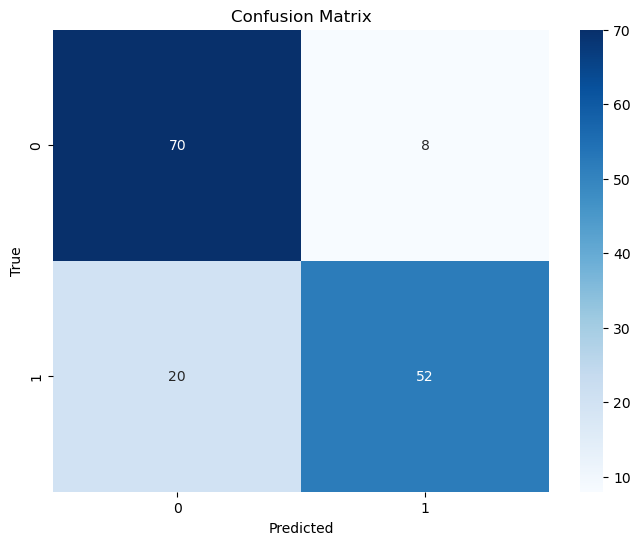

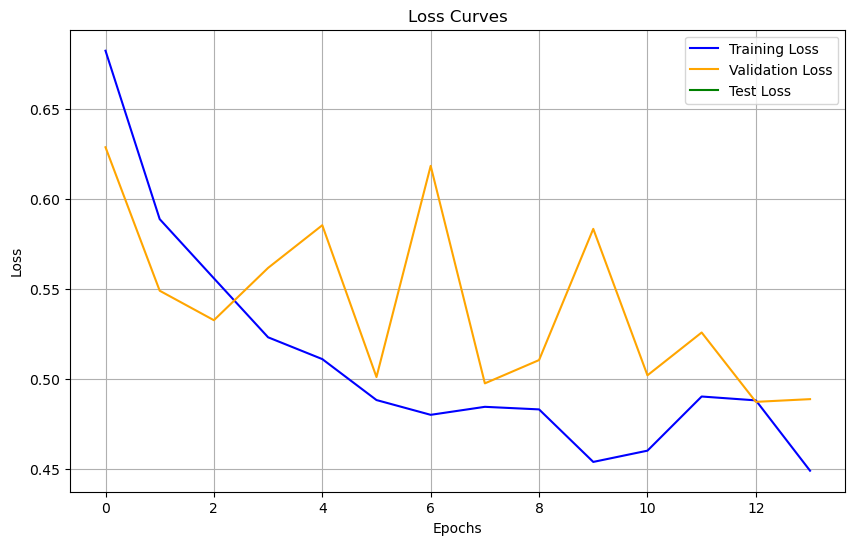

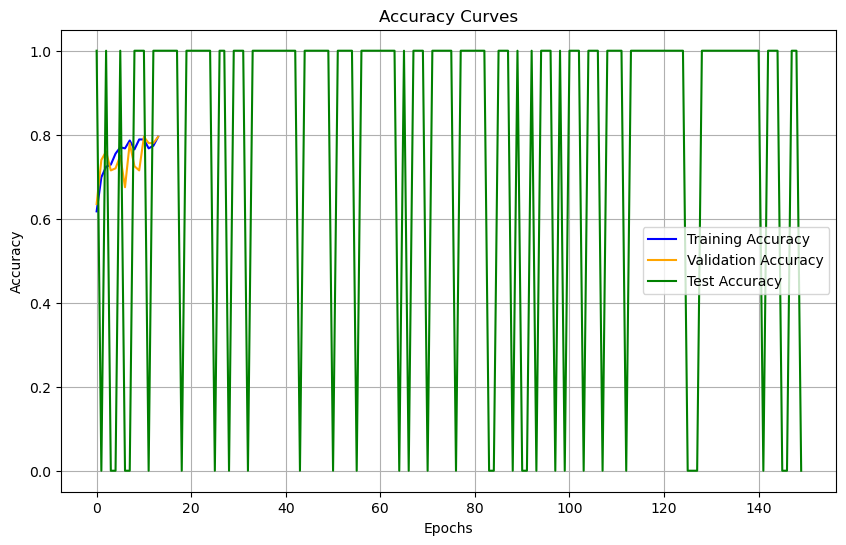

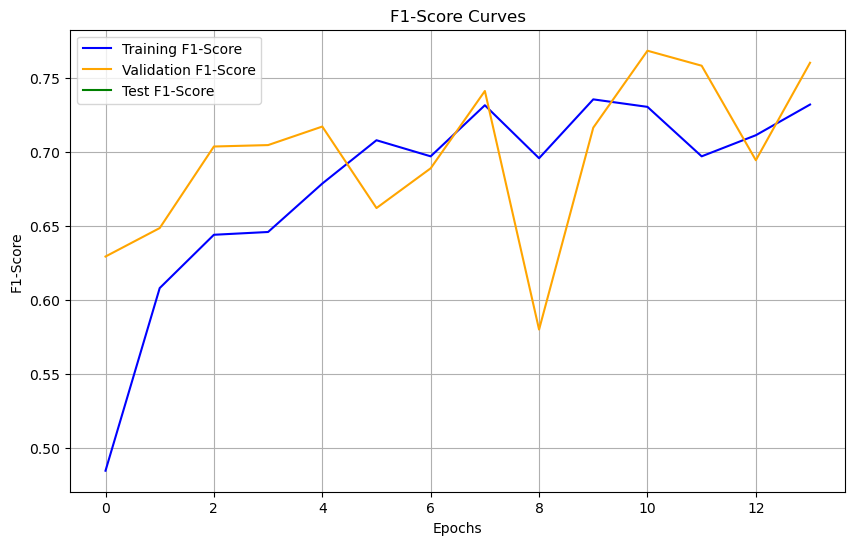

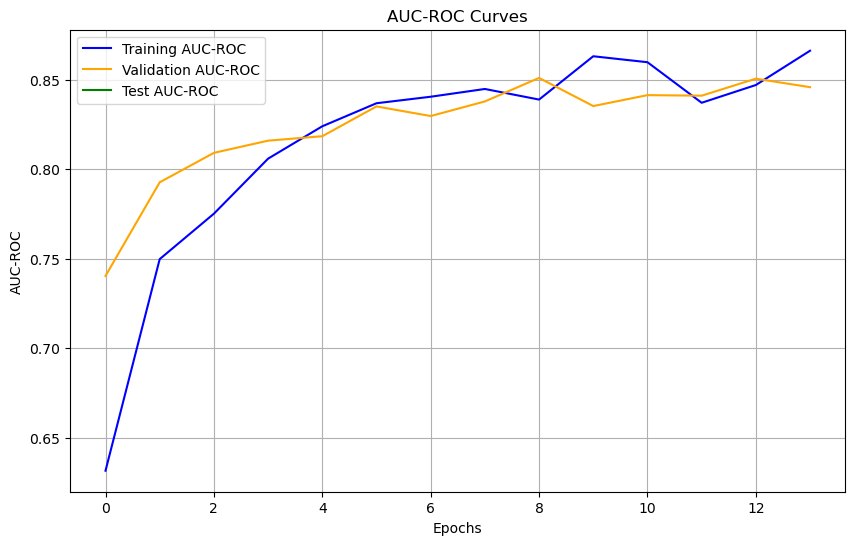

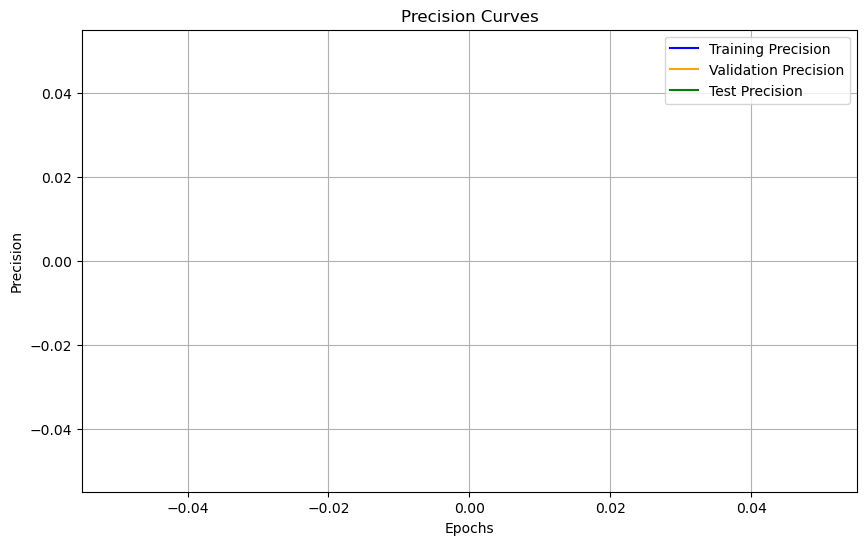

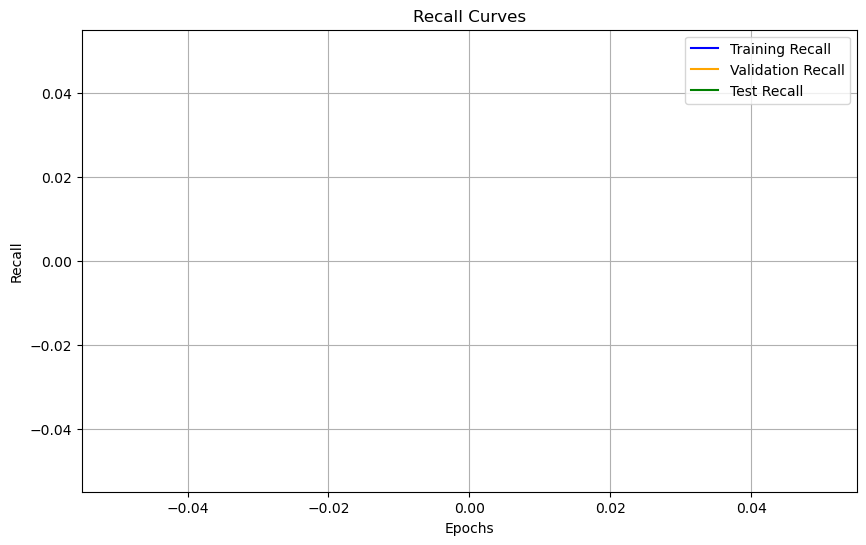

epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
test_accuracy,▁
test_auc,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▄▅▅▆▇▇█▇██▇▇█
train_auc,▁▅▅▆▇▇▇▇▇██▇▇█
train_f1,▁▄▅▆▆▇▇█▇██▇▇█
train_loss,█▅▄▃▃▂▂▂▂▁▁▂▂▁
val_accuracy,▁▆▆▄▅▆▃▇▅▄█▇▇█


In [7]:
# Convertir config_1 en un objeto usando Box
config_1 = Box({
    "dataset_name": "rsna-features_resnet18",
    "num_epochs": 50,
    "learning_rate": 1e-3,
    "batch_size": 1,
    "val_prop": 0.2,
    "seed": 42,
    "use_inst_distances": False,
    "adj_mat_mode": "relative"
})

# Ejecutar el experimento
run_experiment(config_1)

*Learning Rate 1e-4*

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


wandb: Currently logged in as: javitrucas (javitrucas-universidad-de-granada) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 1000 already processed bags
[RSNADataset] Number of bags found: 1000
rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 150 already processed bags
[RSNADataset] Number of bags found: 150


/home/javitrucas/miniconda3/envs/tfg/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50
Train - Loss: 0.6910, Acc: 0.5800, AUC: 0.5089, F1: 0.1295
Val   - Loss: 0.6606, Acc: 0.5900, AUC: 0.6723, F1: 0.0000
Final model saved to ./models/rsna/model.pth


/home/javitrucas/miniconda3/envs/tfg/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 2/50
Train - Loss: 0.6630, Acc: 0.5925, AUC: 0.6223, F1: 0.2010
Val   - Loss: 0.6505, Acc: 0.5900, AUC: 0.7124, F1: 0.0000
Final model saved to ./models/rsna/model.pth
Epoch 3/50
Train - Loss: 0.6386, Acc: 0.6425, AUC: 0.6893, F1: 0.3616
Val   - Loss: 0.6321, Acc: 0.6150, AUC: 0.7246, F1: 0.1149
Final model saved to ./models/rsna/model.pth
Epoch 4/50
Train - Loss: 0.6073, Acc: 0.6925, AUC: 0.7476, F1: 0.5020
Val   - Loss: 0.6096, Acc: 0.7200, AUC: 0.7366, F1: 0.5821
Final model saved to ./models/rsna/model.pth
Epoch 5/50
Train - Loss: 0.5875, Acc: 0.7125, AUC: 0.7669, F1: 0.5788
Val   - Loss: 0.5957, Acc: 0.7150, AUC: 0.7438, F1: 0.6069
Final model saved to ./models/rsna/model.pth
Epoch 6/50
Train - Loss: 0.5631, Acc: 0.7450, AUC: 0.7811, F1: 0.6483
Val   - Loss: 0.5786, Acc: 0.7200, AUC: 0.7586, F1: 0.6216
Final model saved to ./models/rsna/model.pth
Epoch 7/50
Train - Loss: 0.5452, Acc: 0.7388, AUC: 0.7965, F1: 0.6415
Val   - Loss: 0.5722, Acc: 0.7300, AUC: 0.7682, F1: 0.5909
F

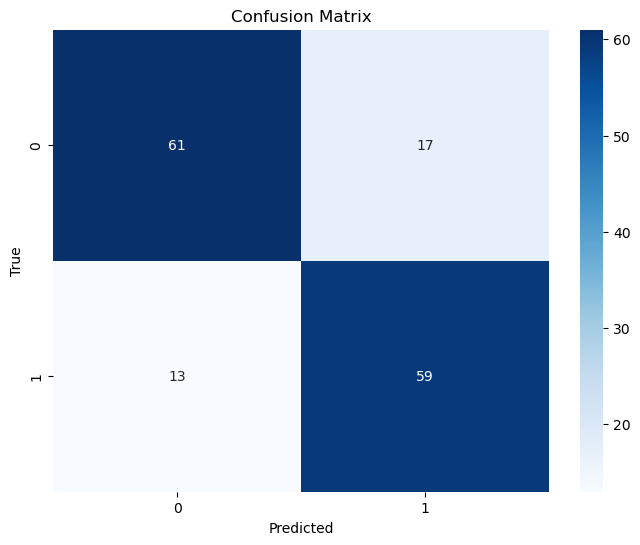

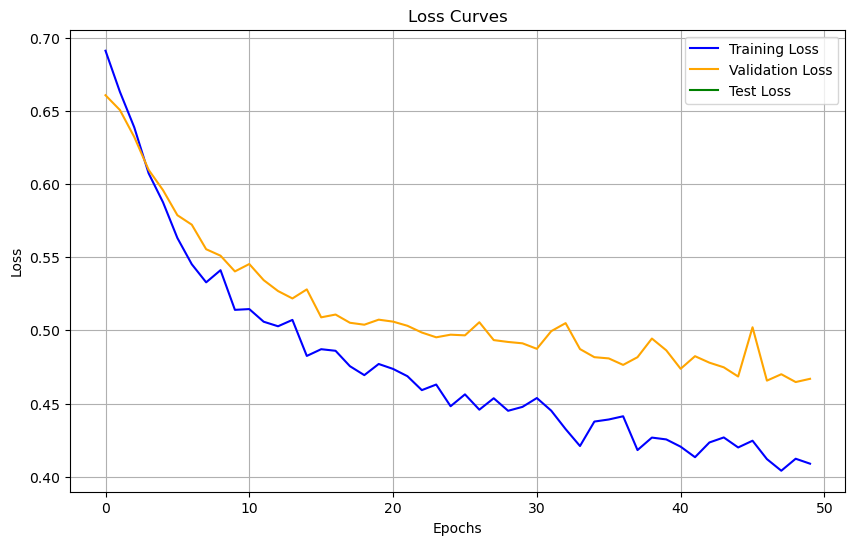

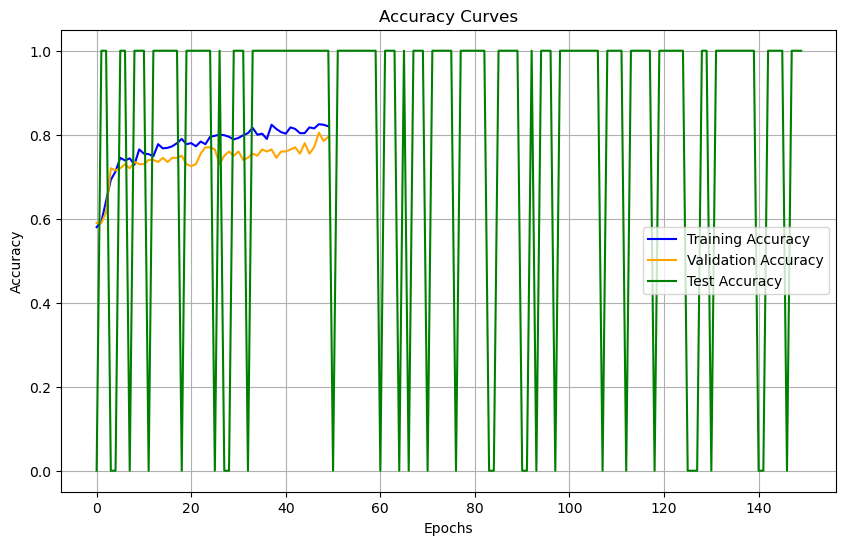

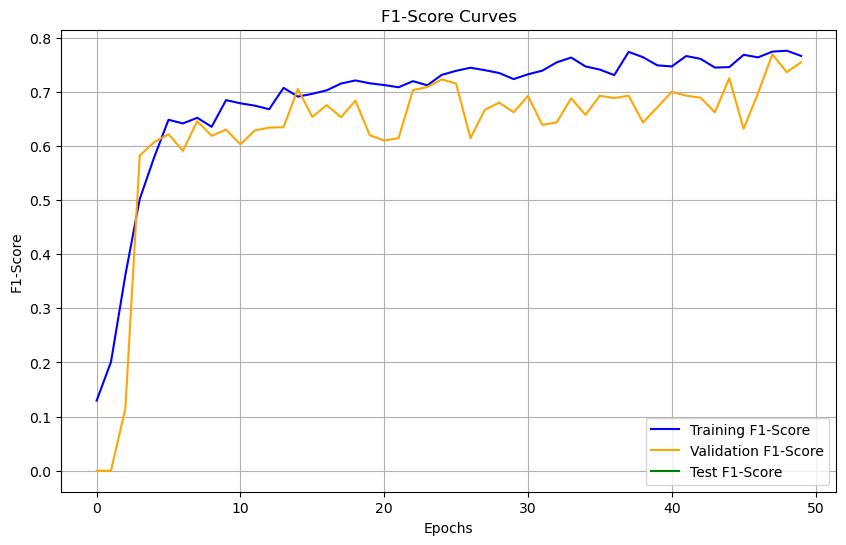

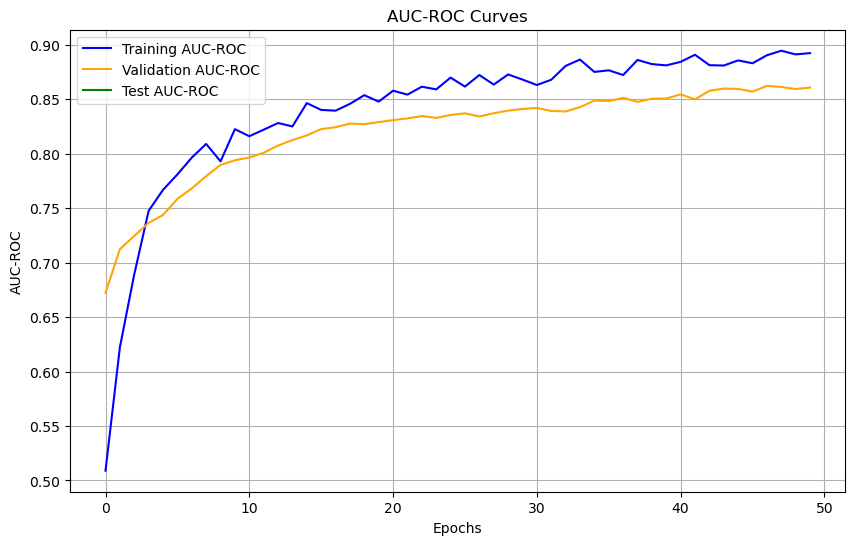

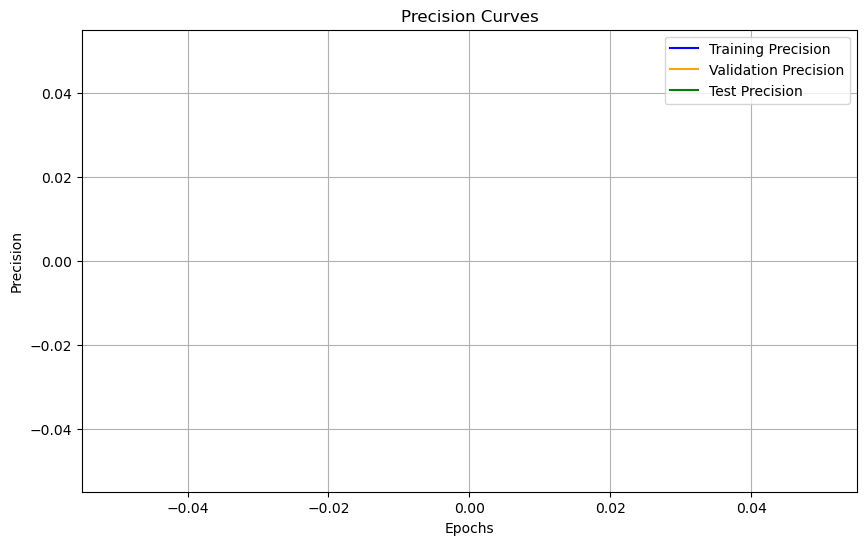

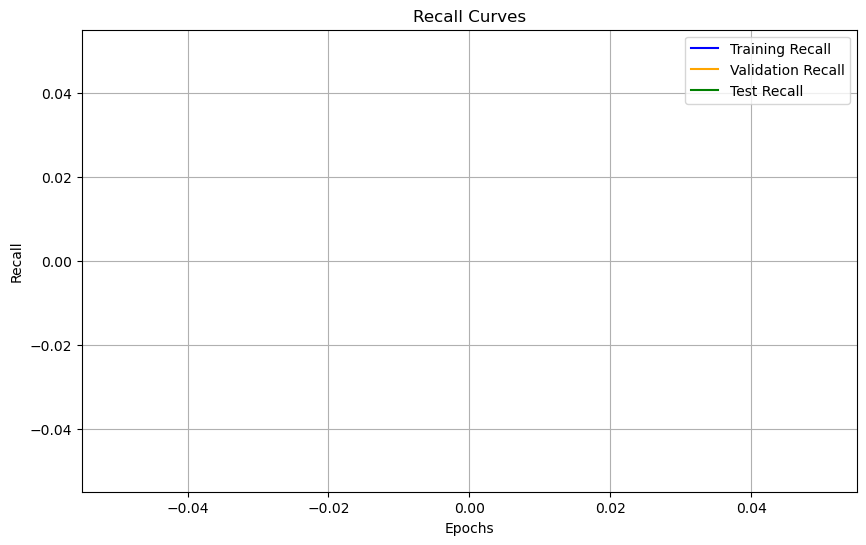

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_accuracy,▁
test_auc,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▁▃▄▅▆▆▅▆▆▆▇▆▆▆▇▇▇▆▇▇▇▇▇▇▇█▇▇▇█▇▇██▇████
train_auc,▁▃▄▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇█████████████████
train_f1,▁▄▅▆▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇████▇███████████████
train_loss,█▇▇▆▅▄▄▄▄▄▃▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▂▂▂▂▁▁▁▁▂▁▁▁
val_accuracy,▁▁▂▅▅▅▆▆▆▆▆▆▆▆▆▆▅▆▇▇▆▆▇▆▇▆▆▆▇▇▆▇▇▇▇▇▆▇██


In [7]:
# Convertir config_1 en un objeto usando Box
config_1 = Box({
    "dataset_name": "rsna-features_resnet18",
    "num_epochs": 50,
    "learning_rate": 1e-4,
    "batch_size": 1,
    "val_prop": 0.2,
    "seed": 42,
    "use_inst_distances": False,
    "adj_mat_mode": "relative"
})

# Ejecutar el experimento
run_experiment(config_1)

*Learning Rate 1e-2*

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


wandb: Currently logged in as: javitrucas (javitrucas-universidad-de-granada) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 1000 already processed bags
[RSNADataset] Number of bags found: 1000
rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 150 already processed bags
[RSNADataset] Number of bags found: 150
Epoch 1/50
Train - Loss: 0.9618, Acc: 0.6188, AUC: 0.6281, F1: 0.5242
Val   - Loss: 0.6373, Acc: 0.7050, AUC: 0.7909, F1: 0.5124
Final model saved to ./models/rsna/model.pth
Epoch 2/50
Train - Loss: 0.9086, Acc: 0.6575, AUC: 0.7132, F1: 0.5678
Val   - Loss: 1.0226, Acc: 0.5750, AUC: 0.8069, F1: 0.6383
Final model saved to ./models/rsna/model.pth
Epoch 3/50
Train - Loss: 0.9640, Acc: 0.6725, AUC: 0.7298, F1: 0.5893
Val   - Loss: 0.6209, Acc: 0.7600, AUC: 0.8137, F1: 0.7209
Final model saved to ./models/rsna/model.pth
Epoch 4/50
Train - Loss: 0.8979, Acc: 0.7100, AUC: 0.7713, F1: 0.6386
Val   - Loss: 0.9900, Acc: 0.6900, AUC: 0.8135, F1: 0.4151


/home/javitrucas/miniconda3/envs/tfg/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 5/50
Train - Loss: 0.8409, Acc: 0.7075, AUC: 0.7702, F1: 0.6422
Val   - Loss: 2.1469, Acc: 0.5900, AUC: 0.7660, F1: 0.0000
Epoch 6/50
Train - Loss: 0.9228, Acc: 0.6963, AUC: 0.7576, F1: 0.6233
Val   - Loss: 0.6622, Acc: 0.7300, AUC: 0.8161, F1: 0.5970
Final model saved to ./models/rsna/model.pth
Epoch 7/50
Train - Loss: 0.8872, Acc: 0.7087, AUC: 0.7713, F1: 0.6388
Val   - Loss: 0.8344, Acc: 0.6950, AUC: 0.8290, F1: 0.7024
Final model saved to ./models/rsna/model.pth
Epoch 8/50
Train - Loss: 0.9074, Acc: 0.7288, AUC: 0.7801, F1: 0.6667
Val   - Loss: 0.6572, Acc: 0.7300, AUC: 0.8268, F1: 0.6351
Epoch 9/50
Train - Loss: 0.7217, Acc: 0.7588, AUC: 0.8259, F1: 0.7044
Val   - Loss: 0.6352, Acc: 0.7450, AUC: 0.8274, F1: 0.6577
Epoch 10/50
Train - Loss: 1.0162, Acc: 0.7063, AUC: 0.7656, F1: 0.6401
Val   - Loss: 0.8588, Acc: 0.7550, AUC: 0.8485, F1: 0.6080
Final model saved to ./models/rsna/model.pth
Epoch 11/50
Train - Loss: 0.8619, Acc: 0.7388, AUC: 0.8056, F1: 0.6780
Val   - Loss: 0.816

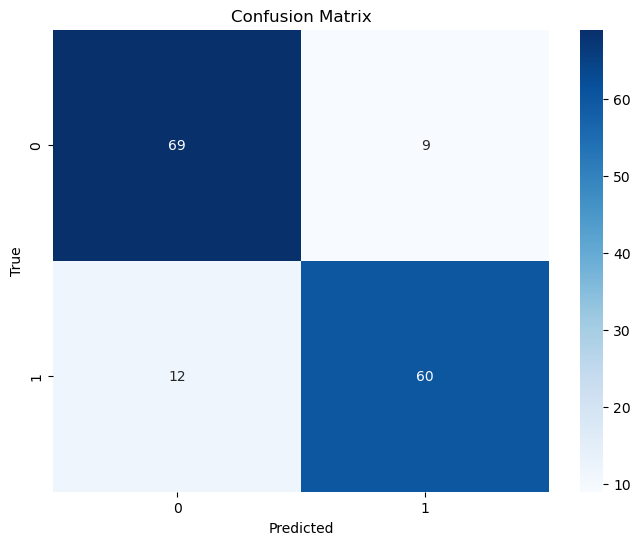

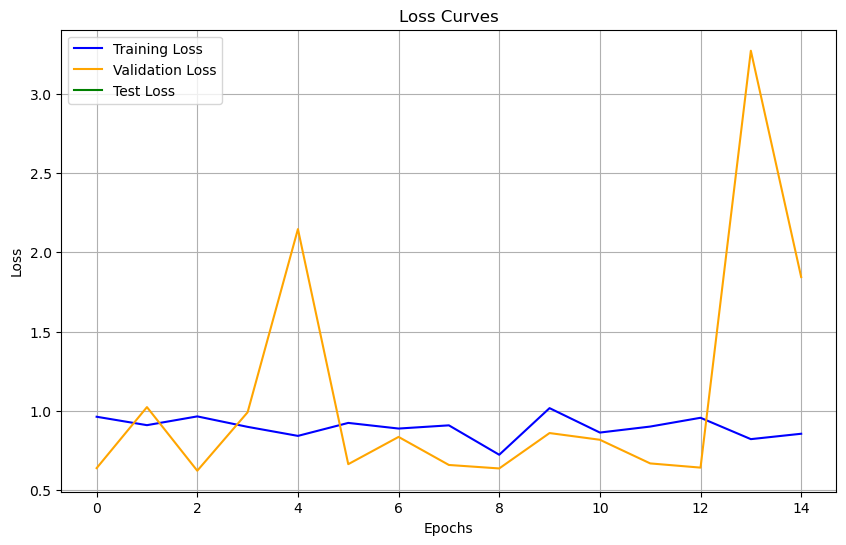

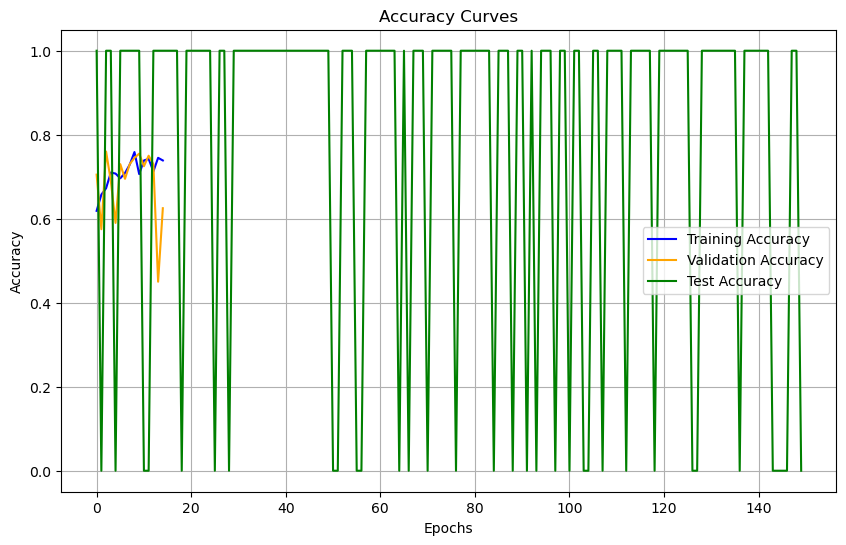

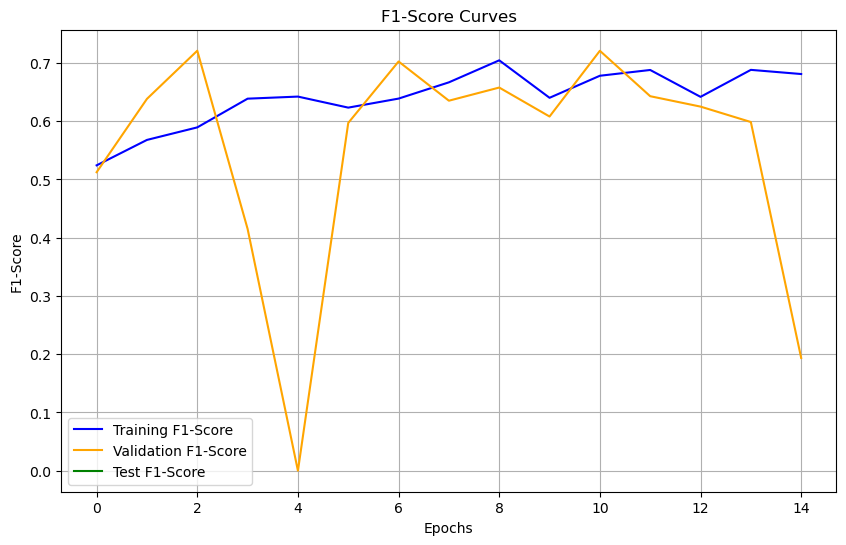

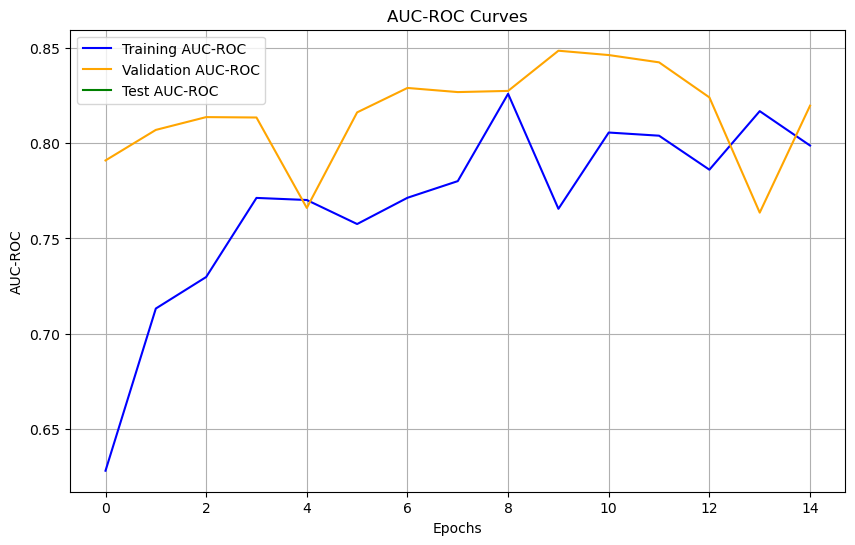

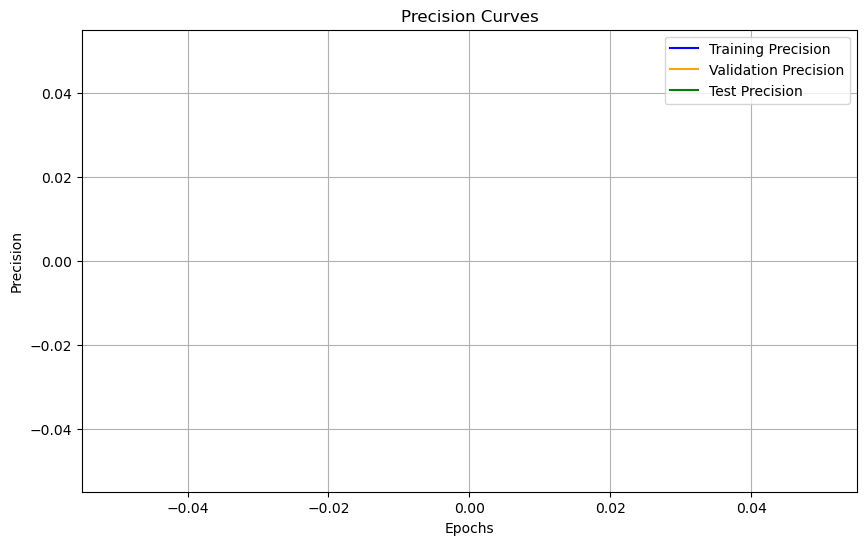

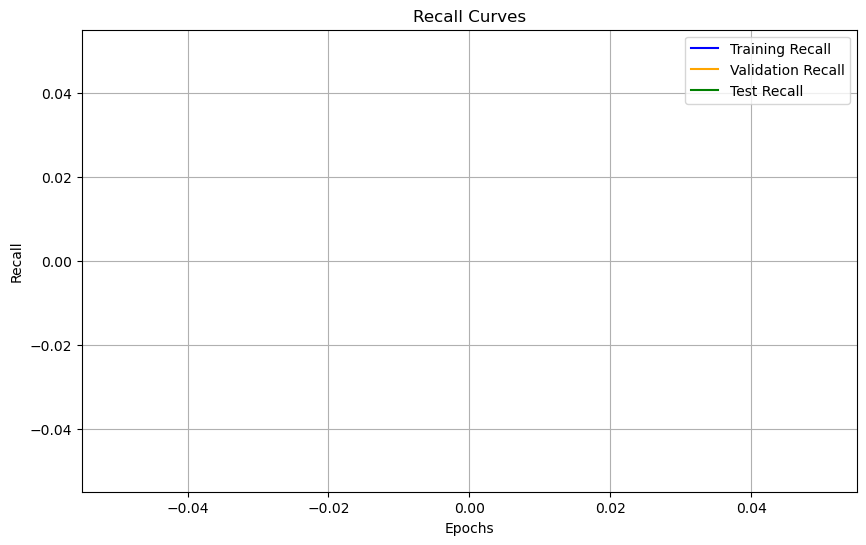

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_accuracy,▁
test_auc,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▃▄▆▅▅▆▆█▅▇▇▆▇▇
train_auc,▁▄▅▆▆▆▆▆█▆▇▇▇█▇
train_f1,▁▃▄▅▆▅▅▇█▆▇▇▆▇▇
train_loss,▇▅▇▅▄▆▅▅▁█▄▅▇▃▄
val_accuracy,▇▄█▆▄▇▇▇██▇█▇▁▅


In [7]:
# Convertir config_1 en un objeto usando Box
config_1 = Box({
    "dataset_name": "rsna-features_resnet18",
    "num_epochs": 50,
    "learning_rate": 1e-2,
    "batch_size": 1,
    "val_prop": 0.2,
    "seed": 42,
    "use_inst_distances": False,
    "adj_mat_mode": "relative"
})

# Ejecutar el experimento
run_experiment(config_1)

**ENTRENAMIENTOS Y RESULTADOS**
**ResNet-50**

In [7]:
# Convertir config_1 en un objeto usando Box
config_1 = Box({
    "dataset_name": "rsna-features_resnet50",
    "num_epochs": 50,
    "learning_rate": 1e-3,
    "batch_size": 1,
    "val_prop": 0.2,
    "seed": 42,
    "use_inst_distances": False,
    "adj_mat_mode": "relative"
})

# Ejecutar el experimento
run_experiment(config_1)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: javitrucas (javitrucas-universidad-de-granada) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 1000 already processed bags
[RSNADataset] Number of bags found: 1000
rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 150 already processed bags
[RSNADataset] Number of bags found: 150


RuntimeError: mat1 and mat2 shapes cannot be multiplied (33x2048 and 512x64)